# Credit Scoring Model
## WOE Binning + Logistic Regression

**Pipeline Overview:**
1. Data Loading & Preprocessing
2. WOE (Weight of Evidence) Transformation
3. Feature Selection (IV + Gini + Multicollinearity)
4. Model Training with Cross-Validation
5. Model Evaluation & Output

**Best Practices Implemented:**
- Unified feature selection pipeline
- Proper train/validation/test split
- Cross-validation for robust evaluation
- Gini coefficient as primary metric
- Multicollinearity removal
- Model serialization for deployment

## 1. Configuration & Imports

In [19]:
import pandas as pd
import numpy as np
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================
# CONFIGURATION - All parameters in one place
# ============================================

# Data settings
TRAIN_PATH = 'data/second_version/train_datamart_ish.csv'
TEST_PATH = 'data/second_version/test_datamart_ish.csv'
OUTPUT_DIR = 'outputs'

# Column settings
TARGET_COL = 'TARGET'
ID_COL = 'MUQAVILE'

# Model settings
RANDOM_STATE = 42
TEST_SIZE = 0.2
N_FOLDS = 5

# Feature engineering settings
NULL_THRESHOLD = 0.95      # Drop columns with >95% nulls
MAX_BINS = 10              # Maximum bins for WOE
MIN_SAMPLES_BIN = 0.05     # Minimum 5% samples per bin

# Feature selection thresholds
MIN_IV = 0.02              # Minimum Information Value
MAX_IV = 0.5               # Maximum IV (exclude suspicious)
MIN_GINI = 0.01            # Minimum univariate Gini
MAX_CORR = 0.85            # Maximum feature correlation
MIN_TARGET_CORR = 0.001    # Minimum correlation with target

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Configuration loaded successfully")
print(f"Output directory: {OUTPUT_DIR}")

Configuration loaded successfully
Output directory: outputs


## 2. Define Pipeline Classes

In [20]:
class DataPreprocessor:
    """Stage 1: Data cleaning and preprocessing"""
    
    def __init__(self, target_col, id_col, null_threshold=0.95):
        self.target_col = target_col
        self.id_col = id_col
        self.null_threshold = null_threshold
        self.cols_to_drop = []
        self.categorical_cols = []
        self.numeric_cols = []
        
    def fit(self, df):
        """Learn preprocessing parameters from training data"""
        # Drop ID column
        self.cols_to_drop = [self.id_col] if self.id_col in df.columns else []
        
        # Drop columns with too many nulls
        null_rates = df.isnull().mean()
        high_null_cols = null_rates[null_rates > self.null_threshold].index.tolist()
        self.cols_to_drop.extend(high_null_cols)
        
        # Identify column types
        remaining_cols = [c for c in df.columns if c not in self.cols_to_drop and c != self.target_col]
        self.categorical_cols = df[remaining_cols].select_dtypes(include=['object']).columns.tolist()
        self.numeric_cols = df[remaining_cols].select_dtypes(include=['number']).columns.tolist()
        
        print(f"Preprocessor fitted:")
        print(f"  - Columns to drop (high nulls): {len(high_null_cols)}")
        print(f"  - Categorical columns: {len(self.categorical_cols)}")
        print(f"  - Numeric columns: {len(self.numeric_cols)}")
        
        return self
    
    def transform(self, df):
        """Apply preprocessing"""
        return df.drop(columns=[c for c in self.cols_to_drop if c in df.columns], errors='ignore')
    
    def fit_transform(self, df):
        return self.fit(df).transform(df)


class WOEBinner:
    """Stage 2: Weight of Evidence transformation"""
    
    def __init__(self, max_bins=10, min_samples_bin=0.05, random_state=42):
        self.max_bins = max_bins
        self.min_samples_bin = min_samples_bin
        self.random_state = random_state
        self.binning_tables = {}
        self.iv_values = {}
        
    def _calculate_woe_iv(self, df, feature, target):
        """Calculate WOE and IV for a binned feature"""
        crosstab = pd.crosstab(df[feature], df[target])
        
        if crosstab.shape[1] < 2:
            return None, 0
        
        crosstab.columns = ['good', 'bad']
        crosstab['total'] = crosstab['good'] + crosstab['bad']
        crosstab['pct_good'] = crosstab['good'] / crosstab['good'].sum()
        crosstab['pct_bad'] = crosstab['bad'] / crosstab['bad'].sum()
        
        # Avoid division by zero
        crosstab['pct_good'] = crosstab['pct_good'].replace(0, 0.0001)
        crosstab['pct_bad'] = crosstab['pct_bad'].replace(0, 0.0001)
        
        crosstab['woe'] = np.log(crosstab['pct_good'] / crosstab['pct_bad'])
        crosstab['iv'] = (crosstab['pct_good'] - crosstab['pct_bad']) * crosstab['woe']
        
        return crosstab, crosstab['iv'].sum()
    
    def _bin_numeric(self, series, target_series):
        """Bin numeric variable using quantile-based binning"""
        is_null = series.isnull()
        non_null_series = series[~is_null]
        
        if len(non_null_series) == 0:
            return pd.Series(['MISSING'] * len(series), index=series.index), {'MISSING': (-np.inf, np.inf)}
        
        n_unique = non_null_series.nunique()
        n_bins = min(self.max_bins, n_unique)
        
        if n_bins <= 1:
            binned = pd.Series(['BIN_1'] * len(series), index=series.index)
            binned[is_null] = 'MISSING'
            return binned, {'BIN_1': (non_null_series.min(), non_null_series.max()), 'MISSING': (np.nan, np.nan)}
        
        try:
            binned_non_null, bin_edges = pd.qcut(non_null_series, q=n_bins, retbins=True, duplicates='drop')
            categories = binned_non_null.cat.categories
            binned_non_null = binned_non_null.astype(str)
        except ValueError:
            try:
                binned_non_null, bin_edges = pd.cut(non_null_series, bins=min(5, n_unique), retbins=True, duplicates='drop')
                categories = binned_non_null.cat.categories
                binned_non_null = binned_non_null.astype(str)
            except:
                binned = pd.Series(['BIN_1'] * len(series), index=series.index)
                binned[is_null] = 'MISSING'
                return binned, {'BIN_1': (series.min(), series.max()), 'MISSING': (np.nan, np.nan)}
        
        binned = pd.Series(index=series.index, dtype=str)
        binned[~is_null] = binned_non_null
        binned[is_null] = 'MISSING'
        
        bins_dict = {str(cat): (bin_edges[i], bin_edges[i+1]) for i, cat in enumerate(categories) if i < len(bin_edges)-1}
        bins_dict['MISSING'] = (np.nan, np.nan)
        
        return binned, bins_dict
    
    def _bin_categorical(self, series):
        """Bin categorical variable"""
        return series.fillna('MISSING').astype(str)
    
    def fit(self, X, y, numeric_cols, categorical_cols):
        """Fit WOE binning on training data"""
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols
        
        df = X.copy()
        df['__target__'] = y.values
        
        total_cols = len(numeric_cols) + len(categorical_cols)
        processed = 0
        
        for col in numeric_cols:
            processed += 1
            if processed % 500 == 0:
                print(f"  WOE binning: {processed}/{total_cols} columns...")
            
            binned, bins_dict = self._bin_numeric(df[col], df['__target__'])
            df[f'{col}_binned'] = binned
            
            woe_table, iv = self._calculate_woe_iv(df, f'{col}_binned', '__target__')
            
            if woe_table is not None:
                self.binning_tables[col] = {
                    'type': 'numeric',
                    'bins': bins_dict,
                    'woe_table': woe_table,
                    'woe_map': woe_table['woe'].to_dict()
                }
                self.iv_values[col] = iv
        
        for col in categorical_cols:
            processed += 1
            binned = self._bin_categorical(df[col])
            df[f'{col}_binned'] = binned
            
            woe_table, iv = self._calculate_woe_iv(df, f'{col}_binned', '__target__')
            
            if woe_table is not None:
                self.binning_tables[col] = {
                    'type': 'categorical',
                    'woe_table': woe_table,
                    'woe_map': woe_table['woe'].to_dict()
                }
                self.iv_values[col] = iv
        
        print(f"WOE binning completed: {len(self.binning_tables)} features")
        return self
    
    def transform(self, X):
        """Transform features to WOE values"""
        X_woe = pd.DataFrame(index=X.index)
        
        for col, binning_info in self.binning_tables.items():
            if col not in X.columns:
                continue
            
            if binning_info['type'] == 'numeric':
                binned, _ = self._bin_numeric(X[col], pd.Series([0]*len(X)))
            else:
                binned = self._bin_categorical(X[col])
            
            woe_map = binning_info['woe_map']
            default_woe = np.mean(list(woe_map.values()))
            X_woe[f'{col}_woe'] = binned.map(woe_map).fillna(default_woe)
        
        return X_woe
    
    def fit_transform(self, X, y, numeric_cols, categorical_cols):
        return self.fit(X, y, numeric_cols, categorical_cols).transform(X)
    
    def get_iv_summary(self):
        """Get IV summary sorted by value"""
        iv_df = pd.DataFrame({
            'feature': list(self.iv_values.keys()),
            'iv': list(self.iv_values.values())
        }).sort_values('iv', ascending=False)
        
        def iv_strength(iv):
            if iv < 0.02: return 'Not useful'
            elif iv < 0.1: return 'Weak'
            elif iv < 0.3: return 'Medium'
            elif iv < 0.5: return 'Strong'
            else: return 'Suspicious'
        
        iv_df['strength'] = iv_df['iv'].apply(iv_strength)
        return iv_df


class FeatureSelector:
    """
    Stage 3: Unified Feature Selection
    
    Combines multiple selection criteria:
    1. Information Value (IV) filtering
    2. Univariate Gini coefficient
    3. Target correlation
    4. Multicollinearity removal
    """
    
    def __init__(self, min_iv=0.02, max_iv=0.5, min_gini=0.01, 
                 max_corr=0.85, min_target_corr=0.001, random_state=42):
        self.min_iv = min_iv
        self.max_iv = max_iv
        self.min_gini = min_gini
        self.max_corr = max_corr
        self.min_target_corr = min_target_corr
        self.random_state = random_state
        
        self.selected_features = []
        self.feature_stats = None
        self.elimination_log = {}
    
    def _calculate_univariate_gini(self, X, y):
        """Calculate univariate Gini for each feature"""
        gini_scores = {}
        n_features = X.shape[1]
        
        for idx, col in enumerate(X.columns):
            if (idx + 1) % 200 == 0:
                print(f"    Gini calculation: {idx + 1}/{n_features}...")
            
            try:
                feature_data = X[[col]].replace([np.inf, -np.inf], np.nan).fillna(0)
                
                if feature_data[col].nunique() <= 1:
                    gini_scores[col] = 0.0
                    continue
                
                model = LogisticRegression(random_state=self.random_state, max_iter=100,
                                          solver='lbfgs', class_weight='balanced')
                model.fit(feature_data, y)
                y_pred = model.predict_proba(feature_data)[:, 1]
                auc = roc_auc_score(y, y_pred)
                gini_scores[col] = abs(2 * auc - 1)
            except:
                gini_scores[col] = 0.0
        
        return gini_scores
    
    def _calculate_target_correlations(self, X, y):
        """Calculate correlation with target"""
        correlations = {}
        for col in X.columns:
            try:
                data = X[col].replace([np.inf, -np.inf], np.nan).fillna(0)
                corr = np.corrcoef(data, y)[0, 1]
                correlations[col] = abs(corr) if not np.isnan(corr) else 0.0
            except:
                correlations[col] = 0.0
        return correlations
    
    def _remove_multicollinear(self, X, gini_scores):
        """Remove highly correlated features, keeping higher Gini"""
        X_clean = X.replace([np.inf, -np.inf], np.nan).fillna(0)
        corr_matrix = X_clean.corr()
        
        features_to_remove = set()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i + 1, len(corr_matrix.columns)):
                if abs(corr_matrix.iloc[i, j]) >= self.max_corr:
                    col_i, col_j = corr_matrix.columns[i], corr_matrix.columns[j]
                    
                    if col_i in features_to_remove or col_j in features_to_remove:
                        continue
                    
                    # Keep feature with higher Gini
                    if gini_scores.get(col_i, 0) >= gini_scores.get(col_j, 0):
                        features_to_remove.add(col_j)
                    else:
                        features_to_remove.add(col_i)
        
        return features_to_remove
    
    def fit(self, X_woe, y, iv_values):
        """
        Fit feature selector with unified selection criteria.
        
        Selection Pipeline:
        1. Filter by IV thresholds
        2. Calculate univariate Gini
        3. Filter by Gini threshold
        4. Filter by target correlation
        5. Remove multicollinear features
        """
        print("\n" + "="*60)
        print("FEATURE SELECTION PIPELINE")
        print("="*60)
        print(f"Starting features: {X_woe.shape[1]}")
        
        # Step 1: IV-based selection
        print(f"\n[Step 1] IV Selection ({self.min_iv} <= IV <= {self.max_iv})...")
        iv_selected = [col.replace('_woe', '') for col in X_woe.columns 
                      if col.replace('_woe', '') in iv_values 
                      and self.min_iv <= iv_values[col.replace('_woe', '')] <= self.max_iv]
        iv_selected_woe = [f'{col}_woe' for col in iv_selected if f'{col}_woe' in X_woe.columns]
        X_iv = X_woe[iv_selected_woe]
        self.elimination_log['iv_filtered'] = X_woe.shape[1] - X_iv.shape[1]
        print(f"    Remaining: {X_iv.shape[1]} (removed {self.elimination_log['iv_filtered']})")
        
        # Step 2: Calculate Gini scores
        print(f"\n[Step 2] Calculating Univariate Gini...")
        gini_scores = self._calculate_univariate_gini(X_iv, y)
        
        # Step 3: Calculate target correlations
        print(f"\n[Step 3] Calculating Target Correlations...")
        target_corrs = self._calculate_target_correlations(X_iv, y)
        
        # Build stats dataframe
        self.feature_stats = pd.DataFrame({
            'feature': list(gini_scores.keys()),
            'gini': list(gini_scores.values()),
            'target_corr': [target_corrs.get(f, 0) for f in gini_scores.keys()],
            'iv': [iv_values.get(f.replace('_woe', ''), 0) for f in gini_scores.keys()]
        }).sort_values('gini', ascending=False)
        
        # Step 4: Filter by Gini
        print(f"\n[Step 4] Gini Filtering (>= {self.min_gini})...")
        gini_passed = set(self.feature_stats[self.feature_stats['gini'] >= self.min_gini]['feature'])
        self.elimination_log['low_gini'] = len(gini_scores) - len(gini_passed)
        print(f"    Remaining: {len(gini_passed)} (removed {self.elimination_log['low_gini']})")
        
        # Step 5: Filter by target correlation
        print(f"\n[Step 5] Target Correlation Filtering (>= {self.min_target_corr})...")
        corr_passed = set(self.feature_stats[self.feature_stats['target_corr'] >= self.min_target_corr]['feature'])
        remaining = gini_passed & corr_passed
        self.elimination_log['low_target_corr'] = len(gini_passed) - len(remaining)
        print(f"    Remaining: {len(remaining)} (removed {self.elimination_log['low_target_corr']})")
        
        # Step 6: Remove multicollinearity
        print(f"\n[Step 6] Multicollinearity Removal (corr < {self.max_corr})...")
        remaining_list = [f for f in X_iv.columns if f in remaining]
        if len(remaining_list) > 1:
            remaining_gini = {f: gini_scores[f] for f in remaining_list}
            multicoll = self._remove_multicollinear(X_iv[remaining_list], remaining_gini)
            self.elimination_log['multicollinear'] = len(multicoll)
            remaining = [f for f in remaining_list if f not in multicoll]
        else:
            remaining = remaining_list
            self.elimination_log['multicollinear'] = 0
        print(f"    Remaining: {len(remaining)} (removed {self.elimination_log['multicollinear']})")
        
        self.selected_features = remaining
        
        # Summary
        print("\n" + "="*60)
        print("FEATURE SELECTION SUMMARY")
        print("="*60)
        print(f"Initial features:        {X_woe.shape[1]}")
        print(f"After IV filter:         {X_woe.shape[1] - self.elimination_log['iv_filtered']}")
        print(f"After Gini filter:       {X_woe.shape[1] - self.elimination_log['iv_filtered'] - self.elimination_log['low_gini']}")
        print(f"After correlation filter:{X_woe.shape[1] - self.elimination_log['iv_filtered'] - self.elimination_log['low_gini'] - self.elimination_log['low_target_corr']}")
        print(f"Final selected:          {len(self.selected_features)}")
        print("="*60)
        
        return self
    
    def transform(self, X_woe):
        """Keep only selected features"""
        available = [f for f in self.selected_features if f in X_woe.columns]
        return X_woe[available].copy()
    
    def fit_transform(self, X_woe, y, iv_values):
        return self.fit(X_woe, y, iv_values).transform(X_woe)
    
    def get_feature_stats(self):
        return self.feature_stats


print("Pipeline classes defined successfully")

Pipeline classes defined successfully


## 3. Load Data

In [21]:
# Load data
train_df = pd.read_csv(TRAIN_PATH, sep=';', encoding='utf-8-sig')
test_df = pd.read_csv(TEST_PATH, sep=';', encoding='utf-8-sig')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nTarget distribution:")
print(train_df[TARGET_COL].value_counts())
print(f"\nTarget rate: {train_df[TARGET_COL].mean()*100:.2f}%")

Train shape: (85955, 2739)
Test shape: (10734, 2739)

Target distribution:
TARGET
0    84315
1     1640
Name: count, dtype: int64

Target rate: 1.91%


## 4. Preprocessing

In [22]:
# Initialize and apply preprocessor
preprocessor = DataPreprocessor(TARGET_COL, ID_COL, NULL_THRESHOLD)
train_clean = preprocessor.fit_transform(train_df)
test_clean = preprocessor.transform(test_df)

print(f"\nCleaned train shape: {train_clean.shape}")
print(f"Cleaned test shape: {test_clean.shape}")

Preprocessor fitted:
  - Columns to drop (high nulls): 652
  - Categorical columns: 3
  - Numeric columns: 2082

Cleaned train shape: (85955, 2086)
Cleaned test shape: (10734, 2086)


## 5. Train/Validation Split

In [23]:
# Separate features and target
X = train_clean.drop(columns=[TARGET_COL])
y = train_clean[TARGET_COL]

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Target rate - Train: {y_train.mean():.4f}, Val: {y_val.mean():.4f}")

Training set: 68764 samples
Validation set: 17191 samples
Target rate - Train: 0.0191, Val: 0.0191


## 6. WOE Transformation

In [24]:
# WOE binning
print("Applying WOE transformation...")
woe_binner = WOEBinner(max_bins=MAX_BINS, min_samples_bin=MIN_SAMPLES_BIN, random_state=RANDOM_STATE)

X_train_woe = woe_binner.fit_transform(
    X_train, y_train,
    preprocessor.numeric_cols,
    preprocessor.categorical_cols
)

print(f"\nWOE transformed shape: {X_train_woe.shape}")

Applying WOE transformation...
  WOE binning: 500/2085 columns...
  WOE binning: 1000/2085 columns...
  WOE binning: 1500/2085 columns...
  WOE binning: 2000/2085 columns...
WOE binning completed: 2085 features

WOE transformed shape: (68764, 2085)


In [25]:
# IV Summary
iv_summary = woe_binner.get_iv_summary()
print("=== Information Value Summary ===")
print(f"\nIV Distribution:")
print(iv_summary['strength'].value_counts())
print(f"\nTop 15 features by IV:")
iv_summary.head(15)

=== Information Value Summary ===

IV Distribution:
strength
Not useful    1251
Weak           554
Medium         269
Strong          11
Name: count, dtype: int64

Top 15 features by IV:


,feature,iv,strength
1891,CC_MXAGE,0.430604,Strong
1896,CC_EXLBDCLS_MXAGE,0.427777,Strong
2083,SAHƏLƏR,0.426434,Strong
1903,CCOL_MXAGE,0.419094,Strong
1908,CCOL_EXLBDCLS_MXAGE,0.415909,Strong
1912,ALL_EXLBDCLS_MXAGE,0.407130,Strong
1909,ALL_MXAGE,0.405267,Strong
2028,AGE,0.389664,Strong
2084,PARTNYORLUQ,0.374670,Strong
2029,FILE_AGE,0.336513,Strong


## 7. Feature Selection (Unified Pipeline)

In [26]:
# Unified feature selection
feature_selector = FeatureSelector(
    min_iv=MIN_IV,
    max_iv=MAX_IV,
    min_gini=MIN_GINI,
    max_corr=MAX_CORR,
    min_target_corr=MIN_TARGET_CORR,
    random_state=RANDOM_STATE
)

X_train_selected = feature_selector.fit_transform(X_train_woe, y_train, woe_binner.iv_values)


FEATURE SELECTION PIPELINE
Starting features: 2085

[Step 1] IV Selection (0.02 <= IV <= 0.5)...
    Remaining: 834 (removed 1251)

[Step 2] Calculating Univariate Gini...
    Gini calculation: 200/834...
    Gini calculation: 400/834...
    Gini calculation: 600/834...
    Gini calculation: 800/834...

[Step 3] Calculating Target Correlations...

[Step 4] Gini Filtering (>= 0.01)...
    Remaining: 834 (removed 0)

[Step 5] Target Correlation Filtering (>= 0.001)...
    Remaining: 834 (removed 0)

[Step 6] Multicollinearity Removal (corr < 0.85)...
    Remaining: 238 (removed 596)

FEATURE SELECTION SUMMARY
Initial features:        2085
After IV filter:         834
After Gini filter:       834
After correlation filter:834
Final selected:          238


In [27]:
# Display top features by Gini
feature_stats = feature_selector.get_feature_stats()
print("=== Top 20 Features by Univariate Gini ===")
print(feature_stats.head(20).to_string(index=False))

=== Top 20 Features by Univariate Gini ===
                    feature     gini  target_corr       iv
               CC_MXAGE_woe 0.356931     0.086968 0.430604
      CC_EXLBDCLS_MXAGE_woe 0.355566     0.086613 0.427777
             CCOL_MXAGE_woe 0.352955     0.085252 0.419094
    CCOL_EXLBDCLS_MXAGE_woe 0.351125     0.084890 0.415909
     ALL_EXLBDCLS_MXAGE_woe 0.350808     0.090697 0.407130
              ALL_MXAGE_woe 0.350160     0.090532 0.405267
                SAHƏLƏR_woe 0.347114     0.082432 0.426434
                    AGE_woe 0.345488     0.087763 0.389664
               FILE_AGE_woe 0.322211     0.079742 0.336513
            PARTNYORLUQ_woe 0.313456     0.077619 0.374670
     ALL_O_MXAGE_MXDLQ1_woe 0.304094     0.072780 0.300848
            ALL_O_MXAGE_woe 0.298738     0.071992 0.286993
CCOL_OLMTUTL_CWPS0_EVER_woe 0.286208     0.069050 0.285534
      CCOL_OLMTUTL_EVER_woe 0.285710     0.069317 0.281946
              WORKGROUP_woe 0.277203     0.072700 0.257272
          CC_

In [28]:
# Transform validation set
X_val_woe = woe_binner.transform(X_val)
X_val_selected = feature_selector.transform(X_val_woe)

# Handle nulls
X_train_final = X_train_selected.fillna(0)
X_val_final = X_val_selected.fillna(0)

print(f"Final training shape: {X_train_final.shape}")
print(f"Final validation shape: {X_val_final.shape}")

Final training shape: (68764, 238)
Final validation shape: (17191, 238)


## 8. Model Training with Cross-Validation

In [29]:
def gini_score(y_true, y_pred):
    """Calculate Gini coefficient"""
    return 2 * roc_auc_score(y_true, y_pred) - 1

def cross_validate_model(X, y, n_folds=5):
    """Stratified K-Fold cross-validation"""
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    
    cv_scores = {'auc': [], 'gini': []}
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        model = LogisticRegression(
            random_state=RANDOM_STATE,
            max_iter=1000,
            class_weight='balanced',
            solver='lbfgs'
        )
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_pred = model.predict_proba(X.iloc[val_idx])[:, 1]
        
        auc = roc_auc_score(y.iloc[val_idx], y_pred)
        gini = gini_score(y.iloc[val_idx], y_pred)
        
        cv_scores['auc'].append(auc)
        cv_scores['gini'].append(gini)
        
        print(f"Fold {fold+1}: AUC = {auc:.4f}, Gini = {gini:.4f}")
    
    print(f"\n=== Cross-Validation Results ===")
    print(f"Mean AUC: {np.mean(cv_scores['auc']):.4f} (+/- {np.std(cv_scores['auc']):.4f})")
    print(f"Mean Gini: {np.mean(cv_scores['gini']):.4f} (+/- {np.std(cv_scores['gini']):.4f})")
    
    return cv_scores

# Run CV
print(f"Running {N_FOLDS}-fold cross-validation...\n")
cv_scores = cross_validate_model(X_train_final, y_train, N_FOLDS)

Running 5-fold cross-validation...

Fold 1: AUC = 0.7659, Gini = 0.5317
Fold 2: AUC = 0.8094, Gini = 0.6187
Fold 3: AUC = 0.7779, Gini = 0.5559
Fold 4: AUC = 0.7869, Gini = 0.5738
Fold 5: AUC = 0.7969, Gini = 0.5939

=== Cross-Validation Results ===
Mean AUC: 0.7874 (+/- 0.0150)
Mean Gini: 0.5748 (+/- 0.0300)


## 9. Train Final Model

In [30]:
# Train final model
final_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
)

final_model.fit(X_train_final, y_train)

# Validation evaluation
y_val_pred = final_model.predict_proba(X_val_final)[:, 1]
val_auc = roc_auc_score(y_val, y_val_pred)
val_gini = gini_score(y_val, y_val_pred)

print(f"=== Validation Results ===")
print(f"Validation AUC: {val_auc:.4f}")
print(f"Validation Gini: {val_gini:.4f}")

# Overfitting check
print(f"\n=== Overfitting Check ===")
print(f"CV Mean Gini: {np.mean(cv_scores['gini']):.4f}")
print(f"Validation Gini: {val_gini:.4f}")
print(f"Difference: {abs(np.mean(cv_scores['gini']) - val_gini):.4f}")

=== Validation Results ===
Validation AUC: 0.7484
Validation Gini: 0.4968

=== Overfitting Check ===
CV Mean Gini: 0.5748
Validation Gini: 0.4968
Difference: 0.0780


## 10. Model Evaluation

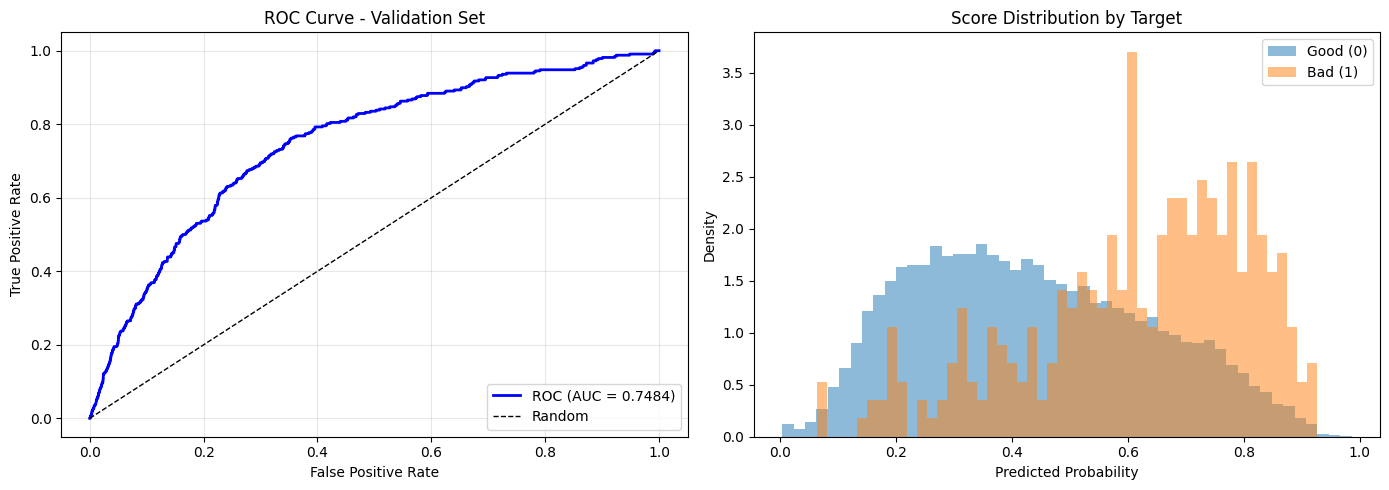

In [31]:
# ROC Curve and Score Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {val_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Validation Set')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Score Distribution
axes[1].hist(y_val_pred[y_val == 0], bins=50, alpha=0.5, label='Good (0)', density=True)
axes[1].hist(y_val_pred[y_val == 1], bins=50, alpha=0.5, label='Bad (1)', density=True)
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Density')
axes[1].set_title('Score Distribution by Target')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/model_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

In [32]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train_final.columns,
    'coefficient': final_model.coef_[0],
    'abs_coefficient': np.abs(final_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("=== Top 20 Most Important Features ===")
print(feature_importance.head(20).to_string(index=False))

=== Top 20 Most Important Features ===
                        feature  coefficient  abs_coefficient
        ALL_OSMTOB_183D365D_woe     1.223484         1.223484
           OL_OACMXLMT_365D_woe     1.195543         1.195543
         CCOL_OSMLMT_182D_O_woe     1.164401         1.164401
CCOL_BNK_LMTUSGHIGH80P_EVER_woe     1.053139         1.053139
   CCOL_OCNT_12MWPS_0_365DP_woe    -1.029019         1.029019
              ALL_OCNT_365D_woe     1.025073         1.025073
              CL_MXINS_EVER_woe     1.015574         1.015574
         ALL_OCNT_91D365D_O_woe     1.005677         1.005677
        CCOL_AVGLMT_91D365D_woe     0.991654         0.991654
      CC_OLMTUTL_183D365D_O_woe    -0.978901         0.978901
        CC_OAVGTOB_183D365D_woe     0.965026         0.965026
 CCOL_OSMTOB_CWPS0_183D365D_woe    -0.935786         0.935786
          CL_OAVGAMT_365D_O_woe     0.923390         0.923390
           CC_OMXLMT_182D_O_woe    -0.902582         0.902582
      CL_OAVGAMT_183D365D_O_woe

## 11. Apply to Test Set

In [33]:
# Process test set through pipeline
X_test = test_clean.drop(columns=[TARGET_COL], errors='ignore')
X_test_woe = woe_binner.transform(X_test)
X_test_selected = feature_selector.transform(X_test_woe)
X_test_final = X_test_selected.fillna(0)

print(f"Test set shape: {X_test_final.shape}")

# Generate predictions
test_predictions = final_model.predict_proba(X_test_final)[:, 1]

print(f"\nPredictions: Min={test_predictions.min():.4f}, Max={test_predictions.max():.4f}, Mean={test_predictions.mean():.4f}")

# Evaluate if target available
if TARGET_COL in test_clean.columns:
    y_test = test_clean[TARGET_COL]
    test_auc = roc_auc_score(y_test, test_predictions)
    test_gini = gini_score(y_test, test_predictions)
    
    print(f"\n=== Test Set Results ===")
    print(f"Test AUC: {test_auc:.4f}")
    print(f"Test Gini: {test_gini:.4f}")
    
    print(f"\n=== Performance Summary ===")
    print(f"{'Dataset':<15} {'AUC':<10} {'Gini':<10}")
    print("-" * 35)
    print(f"{'CV (mean)':<15} {np.mean(cv_scores['auc']):<10.4f} {np.mean(cv_scores['gini']):<10.4f}")
    print(f"{'Validation':<15} {val_auc:<10.4f} {val_gini:<10.4f}")
    print(f"{'Test':<15} {test_auc:<10.4f} {test_gini:<10.4f}")

Test set shape: (10734, 238)

Predictions: Min=0.0129, Max=0.9356, Mean=0.2517

=== Test Set Results ===
Test AUC: 0.7102
Test Gini: 0.4204

=== Performance Summary ===
Dataset         AUC        Gini      
-----------------------------------
CV (mean)       0.7874     0.5748    
Validation      0.7484     0.4968    
Test            0.7102     0.4204    


## 11.1 Hyperparameter Optimization (Optuna)

Using Bayesian optimization to find optimal regularization parameters.

In [34]:
# Optimization imports
import optuna
from optuna.pruners import MedianPruner
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import log_loss, brier_score_loss

# Reduce Optuna verbosity
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("Optimization libraries loaded successfully")

Optimization libraries loaded successfully


In [35]:
class ModelOptimizer:
    """
    Bayesian Hyperparameter Optimization for Logistic Regression using Optuna.
    
    Optimizes:
    - C (regularization strength): log-uniform [0.001, 100]
    - penalty: ['l1', 'l2', 'elasticnet']
    - l1_ratio: [0.1, 0.9] (only for elasticnet)
    
    Uses SAGA solver which supports all penalty types.
    """
    
    def __init__(self, X, y, n_folds=5, random_state=42):
        self.X = X
        self.y = y
        self.n_folds = n_folds
        self.random_state = random_state
        self.study = None
        self.best_params = None
    
    def objective(self, trial):
        """Optuna objective function - maximizes CV Gini"""
        # Hyperparameter search space
        C = trial.suggest_float('C', 0.001, 100, log=True)
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
        
        params = {
            'C': C,
            'penalty': penalty,
            'solver': 'saga',
            'max_iter': 1000,
            'random_state': self.random_state,
            'class_weight': 'balanced'
        }
        
        # l1_ratio only applies to elasticnet
        if penalty == 'elasticnet':
            params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.1, 0.9)
        
        # Stratified K-Fold cross-validation
        skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, 
                              random_state=self.random_state)
        gini_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(self.X, self.y)):
            try:
                model = LogisticRegression(**params)
                model.fit(self.X.iloc[train_idx], self.y.iloc[train_idx])
                y_pred = model.predict_proba(self.X.iloc[val_idx])[:, 1]
                gini = 2 * roc_auc_score(self.y.iloc[val_idx], y_pred) - 1
                gini_scores.append(gini)
                
                # Report intermediate value for pruning
                trial.report(np.mean(gini_scores), fold)
                
                # Prune unpromising trials
                if trial.should_prune():
                    raise optuna.TrialPruned()
            except Exception as e:
                return 0.0  # Return low score for failed trials
        
        return np.mean(gini_scores)
    
    def optimize(self, n_trials=100):
        """Run Bayesian optimization"""
        self.study = optuna.create_study(
            direction='maximize',
            pruner=MedianPruner(n_warmup_steps=2)
        )
        
        self.study.optimize(
            self.objective, 
            n_trials=n_trials,
            show_progress_bar=True
        )
        
        self.best_params = self.study.best_params
        return self.best_params
    
    def get_optimization_history(self):
        """Get dataframe of all trials"""
        return self.study.trials_dataframe()
    
    def get_best_model_params(self):
        """Get full parameter dict for best model"""
        params = {
            'C': self.best_params['C'],
            'penalty': self.best_params['penalty'],
            'solver': 'saga',
            'max_iter': 1000,
            'random_state': self.random_state,
            'class_weight': 'balanced'
        }
        if self.best_params['penalty'] == 'elasticnet':
            params['l1_ratio'] = self.best_params['l1_ratio']
        return params

print("ModelOptimizer class defined successfully")

ModelOptimizer class defined successfully


In [36]:
# Run Bayesian Hyperparameter Optimization
print("="*60)
print("BAYESIAN HYPERPARAMETER OPTIMIZATION")
print("="*60)
print(f"Trials: 100 | Folds: {N_FOLDS} | Objective: Maximize CV Gini")
print("="*60 + "\n")

optimizer = ModelOptimizer(X_train_final, y_train, n_folds=N_FOLDS, random_state=RANDOM_STATE)
best_params = optimizer.optimize(n_trials=100)

print(f"\n{'='*60}")
print("BEST HYPERPARAMETERS FOUND")
print("="*60)
for param, value in best_params.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.6f}")
    else:
        print(f"  {param}: {value}")
print(f"\nBest CV Gini: {optimizer.study.best_value:.4f}")
print(f"Baseline CV Gini: {np.mean(cv_scores['gini']):.4f}")
print(f"CV Improvement: {(optimizer.study.best_value - np.mean(cv_scores['gini']))*100:+.2f}%")

BAYESIAN HYPERPARAMETER OPTIMIZATION
Trials: 100 | Folds: 5 | Objective: Maximize CV Gini



  0%|          | 0/100 [00:00<?, ?it/s]


BEST HYPERPARAMETERS FOUND
  C: 0.004694
  penalty: elasticnet
  l1_ratio: 0.587123

Best CV Gini: 0.6016
Baseline CV Gini: 0.5748
CV Improvement: +2.68%


In [37]:
# Train optimized model with best hyperparameters
opt_params = optimizer.get_best_model_params()

print("Training optimized model with parameters:")
for k, v in opt_params.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.6f}")
    else:
        print(f"  {k}: {v}")

optimized_model = LogisticRegression(**opt_params)
optimized_model.fit(X_train_final, y_train)

# Evaluate on validation set
y_val_pred_opt = optimized_model.predict_proba(X_val_final)[:, 1]
opt_val_auc = roc_auc_score(y_val, y_val_pred_opt)
opt_val_gini = 2 * opt_val_auc - 1

print(f"\n=== Optimized Model - Validation Results ===")
print(f"Optimized Validation AUC:  {opt_val_auc:.4f}")
print(f"Optimized Validation Gini: {opt_val_gini:.4f}")
print(f"Baseline Validation Gini:  {val_gini:.4f}")
print(f"Improvement: {(opt_val_gini - val_gini)*100:+.2f}%")

Training optimized model with parameters:
  C: 0.004694
  penalty: elasticnet
  solver: saga
  max_iter: 1000
  random_state: 42
  class_weight: balanced
  l1_ratio: 0.587123

=== Optimized Model - Validation Results ===
Optimized Validation AUC:  0.7427
Optimized Validation Gini: 0.4855
Baseline Validation Gini:  0.4968
Improvement: -1.13%


In [38]:
# Apply Isotonic Probability Calibration
print("Applying isotonic probability calibration...")

calibrated_model = CalibratedClassifierCV(
    optimized_model, 
    method='isotonic', 
    cv=5
)
calibrated_model.fit(X_train_final, y_train)

# Evaluate calibrated model
y_val_pred_cal = calibrated_model.predict_proba(X_val_final)[:, 1]
cal_val_auc = roc_auc_score(y_val, y_val_pred_cal)
cal_val_gini = 2 * cal_val_auc - 1

# Calculate Brier scores (lower is better)
brier_baseline = brier_score_loss(y_val, y_val_pred)
brier_opt = brier_score_loss(y_val, y_val_pred_opt)
brier_cal = brier_score_loss(y_val, y_val_pred_cal)

# Calculate Log Loss (lower is better)
logloss_baseline = log_loss(y_val, y_val_pred)
logloss_opt = log_loss(y_val, y_val_pred_opt)
logloss_cal = log_loss(y_val, y_val_pred_cal)

print("\n" + "="*70)
print("CALIBRATION COMPARISON - VALIDATION SET")
print("="*70)
print(f"{'Model':<20} {'Gini':<10} {'Brier':<12} {'Log-Loss':<12}")
print("-" * 70)
print(f"{'Baseline':<20} {val_gini:<10.4f} {brier_baseline:<12.4f} {logloss_baseline:<12.4f}")
print(f"{'Optimized':<20} {opt_val_gini:<10.4f} {brier_opt:<12.4f} {logloss_opt:<12.4f}")
print(f"{'Calibrated':<20} {cal_val_gini:<10.4f} {brier_cal:<12.4f} {logloss_cal:<12.4f}")
print("="*70)

# Determine best model based on Brier score
use_calibrated = brier_cal < brier_opt
print(f"\nRecommendation: {'Calibrated' if use_calibrated else 'Optimized'} model has better Brier score")

Applying isotonic probability calibration...

CALIBRATION COMPARISON - VALIDATION SET
Model                Gini       Brier        Log-Loss    
----------------------------------------------------------------------
Baseline             0.4968     0.2279       0.6505      
Optimized            0.4855     0.2102       0.6090      
Calibrated           0.5118     0.0184       0.0873      

Recommendation: Calibrated model has better Brier score


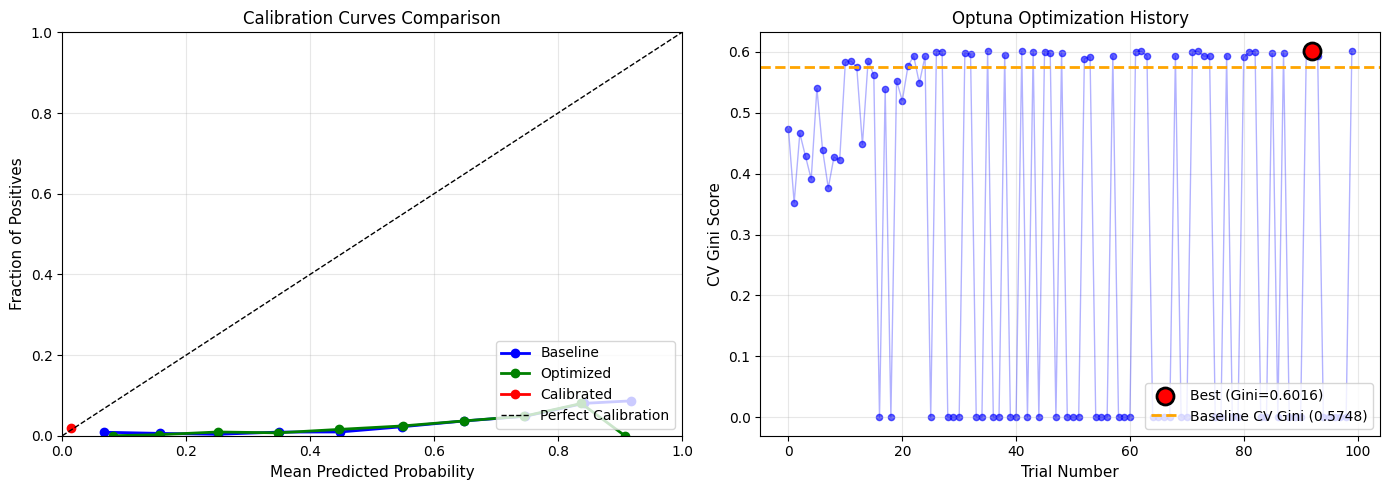


Plot saved to 'outputs/optimization_results.png'


In [39]:
# Visualization: Calibration Curves and Optimization History
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Calibration Curves
for name, preds, color in [('Baseline', y_val_pred, 'blue'),
                           ('Optimized', y_val_pred_opt, 'green'),
                           ('Calibrated', y_val_pred_cal, 'red')]:
    prob_true, prob_pred = calibration_curve(y_val, preds, n_bins=10, strategy='uniform')
    axes[0].plot(prob_pred, prob_true, marker='o', label=name, color=color, linewidth=2)

axes[0].plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=1)
axes[0].set_xlabel('Mean Predicted Probability', fontsize=11)
axes[0].set_ylabel('Fraction of Positives', fontsize=11)
axes[0].set_title('Calibration Curves Comparison', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# Plot 2: Optimization History
history = optimizer.get_optimization_history()
completed_trials = history[history['state'] == 'COMPLETE']

axes[1].plot(completed_trials['number'], completed_trials['value'], 'b-', alpha=0.3, linewidth=1)
axes[1].scatter(completed_trials['number'], completed_trials['value'], c='blue', s=20, alpha=0.6)

# Highlight best trial
best_idx = completed_trials['value'].idxmax()
best_trial = completed_trials.loc[best_idx]
axes[1].scatter(best_trial['number'], best_trial['value'], 
               c='red', s=150, zorder=5, label=f'Best (Gini={best_trial["value"]:.4f})', 
               edgecolors='black', linewidth=2)

# Add baseline reference line
axes[1].axhline(y=np.mean(cv_scores['gini']), color='orange', linestyle='--', 
               label=f'Baseline CV Gini ({np.mean(cv_scores["gini"]):.4f})', linewidth=2)

axes[1].set_xlabel('Trial Number', fontsize=11)
axes[1].set_ylabel('CV Gini Score', fontsize=11)
axes[1].set_title('Optuna Optimization History', fontsize=12)
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/optimization_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to '{OUTPUT_DIR}/optimization_results.png'")

In [40]:
# Final Test Set Evaluation
# Select best model based on calibration
final_opt_model = calibrated_model if use_calibrated else optimized_model
model_type = "Calibrated" if use_calibrated else "Optimized"

# Test predictions with optimized model
y_test_pred_opt = final_opt_model.predict_proba(X_test_final)[:, 1]
opt_test_auc = roc_auc_score(y_test, y_test_pred_opt)
opt_test_gini = 2 * opt_test_auc - 1

# Test metrics
brier_test_baseline = brier_score_loss(y_test, test_predictions)
brier_test_opt = brier_score_loss(y_test, y_test_pred_opt)

print("="*70)
print("FINAL MODEL COMPARISON - ALL DATASETS")
print("="*70)
print(f"\n{'Dataset':<15} {'Baseline Gini':<15} {f'{model_type} Gini':<15} {'Change':<12}")
print("-" * 70)
print(f"{'CV (mean)':<15} {np.mean(cv_scores['gini']):<15.4f} {optimizer.study.best_value:<15.4f} "
      f"{(optimizer.study.best_value - np.mean(cv_scores['gini']))*100:+.2f}%")

val_gini_final = cal_val_gini if use_calibrated else opt_val_gini
print(f"{'Validation':<15} {val_gini:<15.4f} {val_gini_final:<15.4f} "
      f"{(val_gini_final - val_gini)*100:+.2f}%")

print(f"{'Test':<15} {test_gini:<15.4f} {opt_test_gini:<15.4f} "
      f"{(opt_test_gini - test_gini)*100:+.2f}%")

print("\n" + "-" * 70)
print(f"\n{'Metric':<20} {'Baseline':<15} {model_type:<15}")
print("-" * 50)
print(f"{'Test Brier Score':<20} {brier_test_baseline:<15.4f} {brier_test_opt:<15.4f}")
print(f"{'Test AUC':<20} {test_auc:<15.4f} {opt_test_auc:<15.4f}")
print(f"{'Test Gini':<20} {test_gini:<15.4f} {opt_test_gini:<15.4f}")

print("\n" + "="*70)
if opt_test_gini > test_gini:
    print(f"SUCCESS: {model_type} model improved Test Gini by {(opt_test_gini - test_gini)*100:.2f}%")
else:
    print(f"NOTE: No improvement in Test Gini (may indicate baseline was well-tuned)")
print("="*70)

FINAL MODEL COMPARISON - ALL DATASETS

Dataset         Baseline Gini   Calibrated Gini Change      
----------------------------------------------------------------------
CV (mean)       0.5748          0.6016          +2.68%
Validation      0.4968          0.5118          +1.50%
Test            0.4204          0.4117          -0.87%

----------------------------------------------------------------------

Metric               Baseline        Calibrated     
--------------------------------------------------
Test Brier Score     0.0929          0.0114         
Test AUC             0.7102          0.7058         
Test Gini            0.4204          0.4117         

NOTE: No improvement in Test Gini (may indicate baseline was well-tuned)


In [41]:
# Save Optimized Model and Optimization Results

# Save optimization history
opt_history = optimizer.get_optimization_history()
opt_history.to_csv(f'{OUTPUT_DIR}/optimization_history.csv', index=False)
print(f"Optimization history saved to '{OUTPUT_DIR}/optimization_history.csv'")

# Save optimized test predictions
opt_output_df = pd.DataFrame({'prediction': y_test_pred_opt})
if ID_COL in test_df.columns:
    opt_output_df[ID_COL] = test_df[ID_COL].values
    opt_output_df = opt_output_df[[ID_COL, 'prediction']]
opt_output_df.to_csv(f'{OUTPUT_DIR}/test_predictions_optimized.csv', index=False)
print(f"Optimized predictions saved to '{OUTPUT_DIR}/test_predictions_optimized.csv'")

# Save optimized model artifacts
optimized_artifacts = {
    'model': final_opt_model,
    'base_optimized_model': optimized_model,
    'preprocessor': preprocessor,
    'woe_binner': woe_binner,
    'feature_selector': feature_selector,
    'best_params': best_params,
    'is_calibrated': use_calibrated,
    'optimization_config': {
        'n_trials': 100,
        'n_folds': N_FOLDS,
        'objective': 'maximize_gini'
    },
    'metrics': {
        'baseline': {
            'cv_gini': np.mean(cv_scores['gini']),
            'val_gini': val_gini,
            'test_gini': test_gini,
            'test_auc': test_auc
        },
        'optimized': {
            'cv_gini': optimizer.study.best_value,
            'val_gini': val_gini_final,
            'test_gini': opt_test_gini,
            'test_auc': opt_test_auc,
            'test_brier': brier_test_opt
        },
        'improvement': {
            'cv_gini': optimizer.study.best_value - np.mean(cv_scores['gini']),
            'val_gini': val_gini_final - val_gini,
            'test_gini': opt_test_gini - test_gini
        }
    },
    'config': {
        'MIN_IV': MIN_IV,
        'MAX_IV': MAX_IV,
        'MIN_GINI': MIN_GINI,
        'MAX_CORR': MAX_CORR,
        'NULL_THRESHOLD': NULL_THRESHOLD
    }
}

with open(f'{OUTPUT_DIR}/credit_scoring_model_optimized.pkl', 'wb') as f:
    pickle.dump(optimized_artifacts, f)

print(f"Optimized model artifacts saved to '{OUTPUT_DIR}/credit_scoring_model_optimized.pkl'")

# Save model comparison
comparison_df = pd.DataFrame({
    'Metric': ['CV Gini', 'Validation Gini', 'Test Gini', 'Test AUC', 'Test Brier'],
    'Baseline': [np.mean(cv_scores['gini']), val_gini, test_gini, test_auc, brier_test_baseline],
    'Optimized': [optimizer.study.best_value, val_gini_final, opt_test_gini, opt_test_auc, brier_test_opt]
})
comparison_df['Change'] = comparison_df['Optimized'] - comparison_df['Baseline']
comparison_df['Change_Pct'] = (comparison_df['Change'] / comparison_df['Baseline'].abs()) * 100
comparison_df.to_csv(f'{OUTPUT_DIR}/model_comparison.csv', index=False)
print(f"Model comparison saved to '{OUTPUT_DIR}/model_comparison.csv'")

Optimization history saved to 'outputs/optimization_history.csv'
Optimized predictions saved to 'outputs/test_predictions_optimized.csv'
Optimized model artifacts saved to 'outputs/credit_scoring_model_optimized.pkl'
Model comparison saved to 'outputs/model_comparison.csv'


## 12. Save Outputs

In [42]:
# Save predictions
output_df = pd.DataFrame({'prediction': test_predictions})
if ID_COL in test_df.columns:
    output_df[ID_COL] = test_df[ID_COL].values
    output_df = output_df[[ID_COL, 'prediction']]

output_df.to_csv(f'{OUTPUT_DIR}/test_predictions.csv', index=False)
print(f"Predictions saved to '{OUTPUT_DIR}/test_predictions.csv'")

# Save IV summary
iv_summary.to_csv(f'{OUTPUT_DIR}/iv_summary.csv', index=False)
print(f"IV summary saved to '{OUTPUT_DIR}/iv_summary.csv'")

# Save feature stats
feature_stats.to_csv(f'{OUTPUT_DIR}/feature_stats.csv', index=False)
print(f"Feature stats saved to '{OUTPUT_DIR}/feature_stats.csv'")

# Save feature importance
feature_importance.to_csv(f'{OUTPUT_DIR}/feature_importance.csv', index=False)
print(f"Feature importance saved to '{OUTPUT_DIR}/feature_importance.csv'")

Predictions saved to 'outputs/test_predictions.csv'
IV summary saved to 'outputs/iv_summary.csv'
Feature stats saved to 'outputs/feature_stats.csv'
Feature importance saved to 'outputs/feature_importance.csv'


In [43]:
# Save model artifacts
model_artifacts = {
    'model': final_model,
    'preprocessor': preprocessor,
    'woe_binner': woe_binner,
    'feature_selector': feature_selector,
    'cv_scores': cv_scores,
    'feature_importance': feature_importance,
    'config': {
        'MIN_IV': MIN_IV,
        'MAX_IV': MAX_IV,
        'MIN_GINI': MIN_GINI,
        'MAX_CORR': MAX_CORR,
        'NULL_THRESHOLD': NULL_THRESHOLD
    }
}

with open(f'{OUTPUT_DIR}/credit_scoring_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print(f"Model artifacts saved to '{OUTPUT_DIR}/credit_scoring_model.pkl'")

Model artifacts saved to 'outputs/credit_scoring_model.pkl'


## 13. Final Summary

In [44]:
print("="*60)
print("CREDIT SCORING MODEL - FINAL SUMMARY")
print("="*60)

print(f"\n1. DATA:")
print(f"   - Training samples: {len(X_train)}")
print(f"   - Validation samples: {len(X_val)}")
print(f"   - Test samples: {len(X_test_final)}")
print(f"   - Target rate: {y_train.mean()*100:.2f}%")

print(f"\n2. FEATURE ENGINEERING:")
print(f"   - Original features: {train_df.shape[1] - 1}")
print(f"   - After preprocessing: {train_clean.shape[1] - 1}")
print(f"   - After WOE transformation: {X_train_woe.shape[1]}")
print(f"   - Final selected features: {X_train_final.shape[1]}")

print(f"\n3. MODEL PERFORMANCE:")
print(f"   - CV Gini: {np.mean(cv_scores['gini']):.4f} (+/- {np.std(cv_scores['gini']):.4f})")
print(f"   - Validation Gini: {val_gini:.4f}")
if TARGET_COL in test_clean.columns:
    print(f"   - Test Gini: {test_gini:.4f}")

print(f"\n4. TOP 5 PREDICTIVE FEATURES:")
for _, row in feature_importance.head(5).iterrows():
    print(f"   - {row['feature'].replace('_woe', '')}: coef={row['coefficient']:.4f}")

print(f"\n5. OUTPUT FILES:")
print(f"   - {OUTPUT_DIR}/test_predictions.csv")
print(f"   - {OUTPUT_DIR}/iv_summary.csv")
print(f"   - {OUTPUT_DIR}/feature_stats.csv")
print(f"   - {OUTPUT_DIR}/feature_importance.csv")
print(f"   - {OUTPUT_DIR}/credit_scoring_model.pkl")
print(f"   - {OUTPUT_DIR}/model_evaluation.png")

print("\n" + "="*60)
print("Model training completed successfully!")
print("="*60)

CREDIT SCORING MODEL - FINAL SUMMARY

1. DATA:
   - Training samples: 68764
   - Validation samples: 17191
   - Test samples: 10734
   - Target rate: 1.91%

2. FEATURE ENGINEERING:
   - Original features: 2738
   - After preprocessing: 2085
   - After WOE transformation: 2085
   - Final selected features: 238

3. MODEL PERFORMANCE:
   - CV Gini: 0.5748 (+/- 0.0300)
   - Validation Gini: 0.4968
   - Test Gini: 0.4204

4. TOP 5 PREDICTIVE FEATURES:
   - ALL_OSMTOB_183D365D: coef=1.2235
   - OL_OACMXLMT_365D: coef=1.1955
   - CCOL_OSMLMT_182D_O: coef=1.1644
   - CCOL_BNK_LMTUSGHIGH80P_EVER: coef=1.0531
   - CCOL_OCNT_12MWPS_0_365DP: coef=-1.0290

5. OUTPUT FILES:
   - outputs/test_predictions.csv
   - outputs/iv_summary.csv
   - outputs/feature_stats.csv
   - outputs/feature_importance.csv
   - outputs/credit_scoring_model.pkl
   - outputs/model_evaluation.png

Model training completed successfully!
